In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

In [2]:
# Cell 1
import os, sys, math, glob, random, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models, utils as tvutils
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
set_seed(42)

Device: cuda


In [3]:
# Cell 2
from pathlib import Path
import os

def find_archive_root(hint="archive"):
    """
    Try to locate the 'archive' directory starting from CWD.
    If CWD already *is* archive, return it. Otherwise look for a child named 'archive'.
    Finally, scan a few guess paths (Desktop/AS10/archive).
    """
    cwd = Path.cwd()
    # Case 1: we're already inside 'archive'
    if cwd.name == hint and cwd.is_dir():
        return cwd

    # Case 2: ./archive relative to current folder
    here = cwd / hint
    if here.is_dir():
        return here

    # Case 3: look one level up
    up = cwd.parent / hint
    if up.is_dir():
        return up

    # Case 4: try a common absolute the user mentioned
    guesses = [
        Path.home() / "Desktop" / "AS10" / "archive",
        Path("/home/akif/Desktop/AS10/archive"),
    ]
    for g in guesses:
        if g.is_dir():
            return g

    # Last resort: walk up a few levels and look for a folder literally named 'archive'
    cur = cwd
    for _ in range(4):
        cand = cur / hint
        if cand.is_dir():
            return cand
        cur = cur.parent

    raise FileNotFoundError("Could not locate the 'archive' directory. "
                            "Set ARCHIVE_ROOT manually to the absolute path.")

# --- detect root and actual left/right dirs ---
ARCHIVE_ROOT = find_archive_root("archive")

# Support both flat and nested patterns
flat_left  = ARCHIVE_ROOT / "left"
flat_right = ARCHIVE_ROOT / "right"
nest_left  = ARCHIVE_ROOT / "left" / "left"
nest_right = ARCHIVE_ROOT / "right" / "right"

LEFT_DIRS_ACTUAL  = []
RIGHT_DIRS_ACTUAL = []

if nest_left.is_dir():
    LEFT_DIRS_ACTUAL.append(nest_left)
if flat_left.is_dir():
    LEFT_DIRS_ACTUAL.append(flat_left)

if nest_right.is_dir():
    RIGHT_DIRS_ACTUAL.append(nest_right)
if flat_right.is_dir():
    RIGHT_DIRS_ACTUAL.append(flat_right)

if not LEFT_DIRS_ACTUAL or not RIGHT_DIRS_ACTUAL:
    raise RuntimeError(
        f"Found archive at: {ARCHIVE_ROOT}\n"
        f"But couldn't find left/right under either pattern:\n"
        f" - {nest_left}\n - {flat_left}\n - {nest_right}\n - {flat_right}"
    )

OUT_DIR = Path("outputs/contrastive")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Archive root:", ARCHIVE_ROOT.resolve())
print("Left dirs found:", [str(p) for p in LEFT_DIRS_ACTUAL])
print("Right dirs found:", [str(p) for p in RIGHT_DIRS_ACTUAL])

Archive root: /home/akif/Desktop/archive
Left dirs found: ['/home/akif/Desktop/archive/left/left', '/home/akif/Desktop/archive/left']
Right dirs found: ['/home/akif/Desktop/archive/right/right', '/home/akif/Desktop/archive/right']


In [4]:
# Cell 2.1
from itertools import islice

def list_some(p, n=3):
    files = [q for q in p.rglob("*") if q.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
    print(f"{p} -> {len(files)} images")
    for q in islice(files, 5):
        print("  -", q.name)
    return files

left_counts = sum(len([q for q in d.rglob('*') if q.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.webp'}]) 
                  for d in LEFT_DIRS_ACTUAL)
right_counts = sum(len([q for q in d.rglob('*') if q.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.webp'}]) 
                   for d in RIGHT_DIRS_ACTUAL)

print(f"Total LEFT images:  {left_counts}")
print(f"Total RIGHT images: {right_counts}")

# Print samples from the first detected left/right directory
if LEFT_DIRS_ACTUAL:  list_some(LEFT_DIRS_ACTUAL[0])
if RIGHT_DIRS_ACTUAL: list_some(RIGHT_DIRS_ACTUAL[0])

Total LEFT images:  12032
Total RIGHT images: 12032
/home/akif/Desktop/archive/left/left -> 6016 images
  - 03977.jpg
  - 01797.jpg
  - 01398.jpg
  - 04041.jpg
  - 04409.jpg
/home/akif/Desktop/archive/right/right -> 6016 images
  - 03977.jpg
  - 01797.jpg
  - 01398.jpg
  - 04041.jpg
  - 04409.jpg


In [5]:
# Cell 3
import pandas as pd

def collect_images(dirs):
    paths = []
    for d in dirs:
        if not d.exists(): 
            continue
        paths += [p for p in d.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
    return paths

left_paths  = collect_images(LEFT_DIRS_ACTUAL)
right_paths = collect_images(RIGHT_DIRS_ACTUAL)

def to_stem_map(paths):
    m = {}
    for p in paths:
        # Use just the filename stem for matching (ignores extension and nested folders)
        m.setdefault(p.stem, []).append(p)
    return m

L = to_stem_map(left_paths)
R = to_stem_map(right_paths)

pairs = []
for stem, llist in L.items():
    if stem in R:
        # pair each left with the first right that shares the stem
        for lp in llist:
            rp = R[stem][0]
            pairs.append((lp, rp))

pairs_df = pd.DataFrame([{"img_a":str(a), "img_b":str(b)} for a,b in pairs]).drop_duplicates()
pairs_df = pairs_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
print("Found pairs:", len(pairs_df))
pairs_df.head()

Found pairs: 6016


img_a  \
0  /home/akif/Desktop/archive/left/left/03405.jpg   
1  /home/akif/Desktop/archive/left/left/01277.jpg   
2  /home/akif/Desktop/archive/left/left/03989.jpg   
3  /home/akif/Desktop/archive/left/left/05754.jpg   
4  /home/akif/Desktop/archive/left/left/05786.jpg   

                                              img_b  
0  /home/akif/Desktop/archive/right/right/03405.jpg  
1  /home/akif/Desktop/archive/right/right/01277.jpg  
2  /home/akif/Desktop/archive/right/right/03989.jpg  
3  /home/akif/Desktop/archive/right/right/05754.jpg  
4  /home/akif/Desktop/archive/right/right/05786.jpg

Wrote: /home/akif/Desktop/AS10/data/pairs.csv rows: 6016


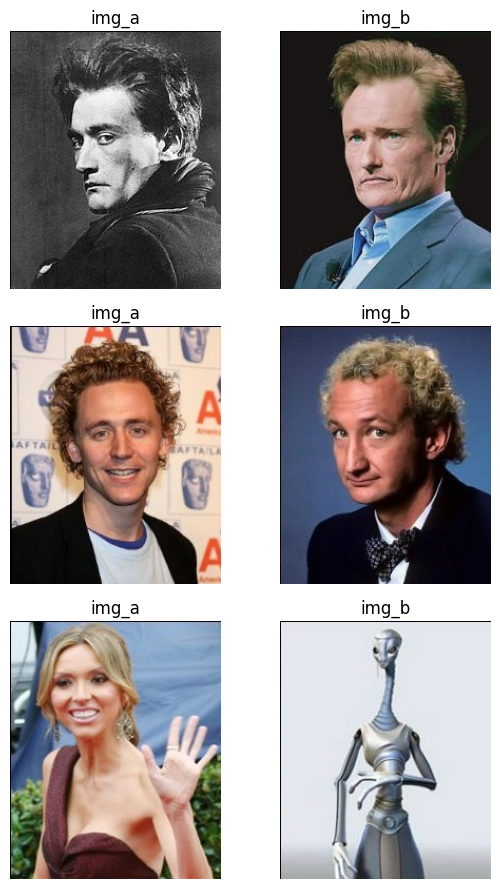

In [6]:
# Cell 4
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
CSV_PATH = DATA_DIR/"pairs.csv"
pairs_df.to_csv(CSV_PATH, index=False)
print("Wrote:", CSV_PATH.resolve(), "rows:", len(pairs_df))

# Preview a few random pairs as a grid
def show_random_pairs(df, n=4, size=3):
    sel = df.sample(n=min(n, len(df)), random_state=7)
    fig, axes = plt.subplots(len(sel), 2, figsize=(2*size, len(sel)*size))
    if len(sel) == 1: axes = np.array([axes])
    for i, (_, r) in enumerate(sel.iterrows()):
        for j, key in enumerate(["img_a","img_b"]):
            axes[i, j].imshow(Image.open(r[key]).convert("RGB"))
            axes[i, j].set_title(key)
            axes[i, j].axis("off")
    plt.tight_layout(); plt.show()

show_random_pairs(pairs_df, n=3)

In [7]:
# Cell 5
class TLLPairs(Dataset):
    """
    Returns (xa, xb, pair_id): positive pair from TLL (left,right).
    Negatives are created in the training step by shuffling within batch.
    """
    def __init__(self, csv_path, augment=True):
        self.df = pd.read_csv(csv_path)
        self.pairs = list(self.df.itertuples(index=False, name=None))

        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225]
        self.train_tf = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.eval_tf = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.augment = augment

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        a_path, b_path = self.pairs[idx]
        xa = Image.open(a_path).convert("RGB")
        xb = Image.open(b_path).convert("RGB")
        tfm = self.train_tf if self.augment else self.eval_tf
        return tfm(xa), tfm(xb), idx  # use row index as pair id

In [8]:
# Cell 6
set_seed(42)

full_ds_train_mode = TLLPairs(CSV_PATH, augment=True)
N = len(full_ds_train_mode)
idx = np.arange(N)
train_idx, test_idx = train_test_split(idx, test_size=0.10, random_state=42)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.1111, random_state=42)  # 0.8/0.1/0.1

ds_train = Subset(full_ds_train_mode, train_idx)
ds_val   = Subset(TLLPairs(CSV_PATH, augment=False), val_idx)
ds_test  = Subset(TLLPairs(CSV_PATH, augment=False), test_idx)

BATCH_SIZE = 128
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, drop_last=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

len(ds_train), len(ds_val), len(ds_test)

(4812, 602, 602)

In [9]:
# Cell 7
class EmbeddingNet(nn.Module):
    def __init__(self, backbone="resnet18", out_dim=256, pretrained=True):
        super().__init__()
        if backbone == "resnet18":
            net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        else:
            net = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        feat_dim = net.fc.in_features
        net.fc = nn.Identity()
        self.backbone = net
        self.head = nn.Sequential(
            nn.Linear(feat_dim, out_dim),
            nn.BatchNorm1d(out_dim)
        )
    def forward(self, x):
        f = self.backbone(x)
        z = self.head(f)
        return F.normalize(z, dim=-1)

model = EmbeddingNet(backbone="resnet18", out_dim=256).to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6

11.308352

In [10]:
# Cell 8
def contrastive_loss(z1, z2, y, margin=0.5):
    # y ∈ {0,1}; L2 distance
    d = (z1 - z2).pow(2).sum(dim=1).sqrt()
    pos = y * d.pow(2)
    neg = (1 - y) * F.relu(margin - d).pow(2)
    return (pos + neg).mean()

def permute_as_negatives(z):
    b = z.size(0)
    perm = torch.randperm(b, device=z.device)
    if (perm == torch.arange(b, device=z.device)).any():
        perm = (perm + 1) % b
    return z[perm]

In [11]:
# Cell 9
LR = 3e-4
EPOCHS = 5
MARGIN = 0.5
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

best_val_posdist = float("inf")
CKPT_PATH = OUT_DIR/"best.pt"

for ep in range(1, EPOCHS+1):
    model.train()
    losses = []
    for xa, xb, _ in dl_train:
        xa, xb = xa.to(DEVICE), xb.to(DEVICE)
        za, zb = model(xa), model(xb)

        y_pos = torch.ones(za.size(0), device=DEVICE)
        y_neg = torch.zeros(za.size(0), device=DEVICE)

        # positive pair loss
        l_pos = contrastive_loss(za, zb, y_pos, margin=MARGIN)
        # negatives by permutation
        zb_neg = permute_as_negatives(zb)
        l_neg = contrastive_loss(za, zb_neg, y_neg, margin=MARGIN)

        loss = 0.5*(l_pos + l_neg)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())

    # simple validation: average positive distance (lower is better)
    model.eval(); dists = []
    with torch.no_grad():
        for xa, xb, _ in dl_val:
            xa, xb = xa.to(DEVICE), xb.to(DEVICE)
            za, zb = model(xa), model(xb)
            d = (za - zb).pow(2).sum(dim=1).sqrt()
            dists += d.tolist()
    val_posdist = float(np.mean(dists))
    print(f"Epoch {ep:02d} | train_loss={np.mean(losses):.4f} | val_pos_dist={val_posdist:.4f}")

    if val_posdist < best_val_posdist:
        best_val_posdist = val_posdist
        torch.save({"ep": ep, "state": model.state_dict()}, CKPT_PATH)
        print("  ✓ saved", CKPT_PATH)

Epoch 01 | train_loss=0.4191 | val_pos_dist=0.4691
  ✓ saved outputs/contrastive/best.pt
Epoch 02 | train_loss=0.1461 | val_pos_dist=0.2436
  ✓ saved outputs/contrastive/best.pt
Epoch 03 | train_loss=0.1018 | val_pos_dist=0.2261
  ✓ saved outputs/contrastive/best.pt
Epoch 04 | train_loss=0.0854 | val_pos_dist=0.2062
  ✓ saved outputs/contrastive/best.pt
Epoch 05 | train_loss=0.1064 | val_pos_dist=0.1862
  ✓ saved outputs/contrastive/best.pt


In [12]:
# Cell 10
# Convention: queries = left (img_a), gallery = right (img_b)
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["state"]); model.eval()

eval_tfm = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def embed_paths(paths):
    embs = []
    with torch.no_grad():
        for p in paths:
            img = Image.open(p).convert("RGB")
            x = eval_tfm(img).unsqueeze(0).to(DEVICE)
            z = model(x).cpu().numpy()[0]
            embs.append(z)
    return np.stack(embs, axis=0)

# Use the WHOLE CSV for retrieval evaluation
all_df = pd.read_csv(CSV_PATH)
Q_paths = all_df["img_a"].tolist()
G_paths = all_df["img_b"].tolist()
labels = np.arange(len(all_df))  # each row is a unique "class"

Q_emb = embed_paths(Q_paths)
G_emb = embed_paths(G_paths)

Q_emb.shape, G_emb.shape

((6016, 256), (6016, 256))

In [13]:
# Cell 11 (revised) — do NOT shadow torch.nn
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=10, metric="cosine").fit(G_emb)
dist, idx = nbrs.kneighbors(Q_emb, n_neighbors=10)

g_labels = labels  # gallery labels per row
q_labels = labels  # query label == its row id
retrieved_labels = g_labels[idx]

def recall_at_k(q_lab, topk_lab, K):
    return (q_lab[:,None] == topk_lab[:, :K]).any(axis=1).mean()

def mean_ap_at_k(q_lab, topk_lab, K):
    ap = []
    for q, row in zip(q_lab, topk_lab):
        pos = np.where(row[:K] == q)[0]
        ap.append(0.0 if len(pos)==0 else 1.0/(pos[0]+1))
    return float(np.mean(ap))

for K in [1,5,10]:
    r = recall_at_k(q_labels, retrieved_labels, K)
    m = mean_ap_at_k(q_labels, retrieved_labels, K)
    print(f"Recall@{K}: {r:.4f} | mAP@{K}: {m:.4f}")

Recall@1: 0.0155 | mAP@1: 0.0155
Recall@5: 0.0331 | mAP@5: 0.0212
Recall@10: 0.0479 | mAP@10: 0.0232


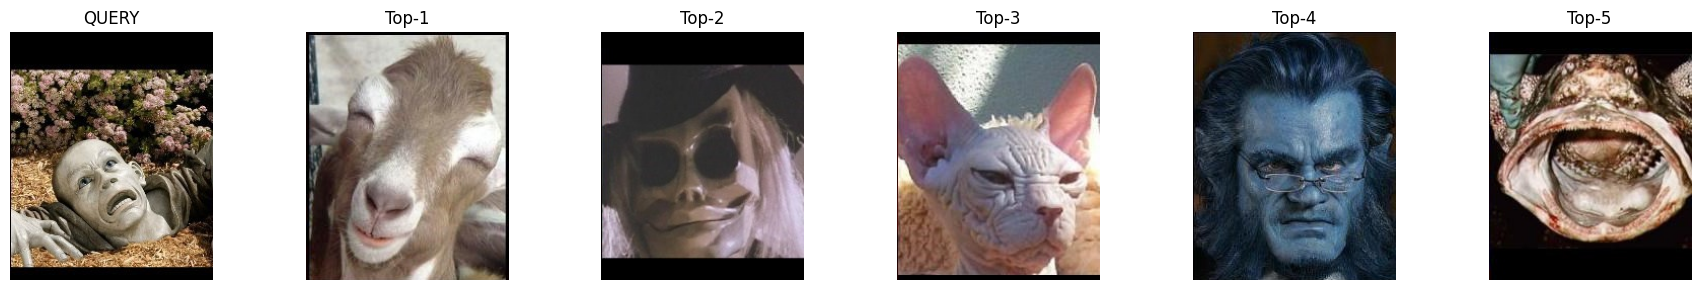

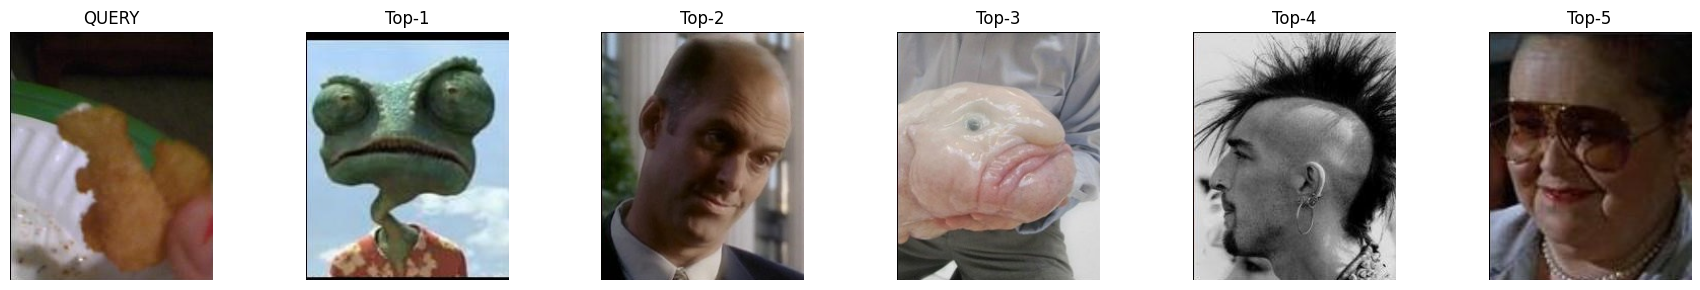

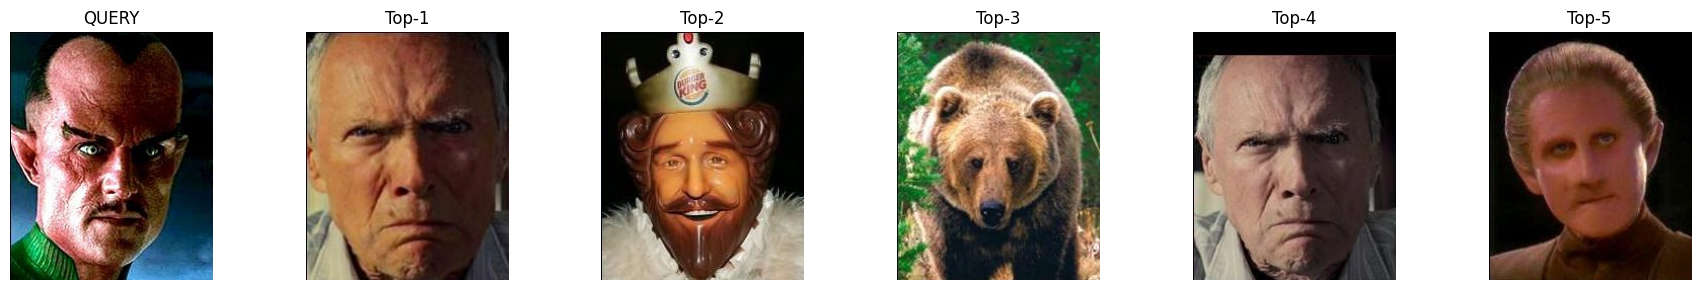

In [14]:
# Cell 12
def show_topk_for(query_idx, topk=5):
    q_path = Q_paths[query_idx]
    top_idx = idx[query_idx][:topk]
    top_paths = [G_paths[i] for i in top_idx]
    titles = ["QUERY"] + [f"Top-{i+1}" for i in range(topk)]
    imgs = [Image.open(q_path).convert("RGB")] + [Image.open(p).convert("RGB") for p in top_paths]

    plt.figure(figsize=(3* (topk+1), 3))
    for i, (im, t) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, topk+1, i+1)
        ax.imshow(im); ax.set_title(t); ax.axis("off")
    plt.tight_layout(); plt.show()

for q in [0, 1, 2]:  # change indices to inspect different queries
    show_topk_for(q, topk=5)

In [15]:
# Cell 13
def save_grid_for(query_idx, topk=5, out_path=OUT_DIR/f"q{0}_top{5}.png"):
    q_path = Q_paths[query_idx]
    top_idx = idx[query_idx][:topk]
    top_paths = [G_paths[i] for i in top_idx]
    imgs = [Image.open(q_path).convert("RGB")] + [Image.open(p).convert("RGB") for p in top_paths]
    # Resize to same shape
    imgs = [im.resize((224,224)) for im in imgs]
    tensor = torch.stack([transforms.ToTensor()(im) for im in imgs], dim=0)
    grid = tvutils.make_grid(tensor, nrow=topk+1, padding=8)
    tvutils.save_image(grid, out_path)
    return out_path

path = save_grid_for(0, topk=5, out_path=OUT_DIR/"example_query_top5.png")
path

PosixPath('outputs/contrastive/example_query_top5.png')

In [16]:
# Cell 14 (revised) — retrieval utils with safe variable names
from typing import Dict, Tuple
from sklearn.neighbors import NearestNeighbors

@torch.no_grad()
def embed_paths_batched(paths, batch_size=128):
    model.eval()
    embs = []
    batch = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = eval_tfm(img).unsqueeze(0)
        batch.append(x)
        if len(batch) == batch_size:
            xb = torch.cat(batch, dim=0).to(DEVICE)
            zb = model(xb).cpu().numpy()
            embs.append(zb); batch = []
    if batch:
        xb = torch.cat(batch, dim=0).to(DEVICE)
        zb = model(xb).cpu().numpy()
        embs.append(zb)
    return np.concatenate(embs, axis=0)

def build_query_gallery_from_indices(indices: np.ndarray) -> Tuple[list, list, np.ndarray]:
    df = pd.read_csv(CSV_PATH)
    sub = df.iloc[indices]
    Q_paths = sub["img_a"].tolist()
    G_paths = sub["img_b"].tolist()
    labels = np.arange(len(sub))  # unique label per row -> exactly 1 true match
    return Q_paths, G_paths, labels

def recall_at_k(q_lab, topk_lab, K):
    return (q_lab[:, None] == topk_lab[:, :K]).any(axis=1).mean()

def mean_ap_at_k(q_lab, topk_lab, K):
    ap = []
    for q, row in zip(q_lab, topk_lab):
        pos = np.where(row[:K] == q)[0]
        ap.append(0.0 if len(pos) == 0 else 1.0 / (pos[0] + 1))
    return float(np.mean(ap))

@torch.no_grad()
def evaluate_split(indices: np.ndarray, topk: int = 10) -> Dict[str, float]:
    # Build query (left) and gallery (right) from the specified subset
    Q_paths, G_paths, labels = build_query_gallery_from_indices(indices)
    Q_emb = embed_paths_batched(Q_paths)
    G_emb = embed_paths_batched(G_paths)

    nbrs = NearestNeighbors(n_neighbors=topk, metric="cosine").fit(G_emb)
    dist, idx = nbrs.kneighbors(Q_emb, n_neighbors=topk)

    retrieved_labels = labels[idx]
    q_labels = labels

    out = {}
    for K in [1, 5, 10]:
        out[f"R@{K}"] = recall_at_k(q_labels, retrieved_labels, K)
        out[f"mAP@{K}"] = mean_ap_at_k(q_labels, retrieved_labels, K)
    return out

In [17]:
# Cell 15
def pairwise_distances(x, y):
    # x: [B, D], y: [B, D] (za vs zb)
    # returns [B, B] with Euclidean distances
    # Both vectors are L2-normalized already; still use Euclidean for losses
    x2 = (x**2).sum(dim=1, keepdim=True)  # [B,1]
    y2 = (y**2).sum(dim=1, keepdim=True).T  # [1,B]
    xy = x @ y.T  # [B,B]
    # ||x - y||^2 = ||x||^2 + ||y||^2 - 2x·y
    d2 = x2 + y2 - 2*xy
    d2 = torch.clamp(d2, min=0)
    return torch.sqrt(d2 + 1e-12)

def select_triplets_semihard(za, zb, margin: float):
    """
    za: [B,D] anchors, zb: [B,D] positives (paired row-wise)
    Returns tensors of indices (ai, pi, ni) for anchors, positives, negatives.
    - Positive for i is fixed to i (paired).
    - Semi-hard negative: choose j != i with d(a_i, z_bj) < d(a_i, z_bi) + margin
      Prefer the *hardest* among semi-hard (largest d(a_i, z_bj)); if none, use batch-hard (smallest d).
    """
    B = za.size(0)
    D = pairwise_distances(za, zb)  # [B,B], D[i,j] = d(a_i, z_bj)
    ai_list, pi_list, ni_list = [], [], []
    for i in range(B):
        d_pos = D[i, i].item()
        semihard_mask = (torch.arange(B, device=za.device) != i) & (D[i] < d_pos + margin)
        candidates = torch.where(semihard_mask)[0]
        if len(candidates) > 0:
            # pick the hardest among semi-hard (largest distance but still < d_pos + m)
            j = candidates[torch.argmax(D[i, candidates])]
        else:
            # batch-hard negative (smallest distance among j != i)
            j = torch.argmin(D[i] + torch.eye(B, device=za.device)[i] * 1e6)
        ai_list.append(i); pi_list.append(i); ni_list.append(j.item())
    return torch.tensor(ai_list, device=za.device), torch.tensor(pi_list, device=za.device), torch.tensor(ni_list, device=za.device)

def contrastive_loss(z1, z2, y, margin=0.5):
    d = (z1 - z2).pow(2).sum(dim=1).sqrt()
    pos = y * d.pow(2)
    neg = (1 - y) * F.relu(margin - d).pow(2)
    return (pos + neg).mean()

def permute_as_negatives(z):
    b = z.size(0)
    perm = torch.randperm(b, device=z.device)
    if (perm == torch.arange(b, device=z.device)).any():
        perm = (perm + 1) % b
    return z[perm]

def validate_recallK(model, val_idx: np.ndarray) -> dict:
    model.eval()
    return evaluate_split(val_idx, topk=10)

def train_one_epoch(model, opt, dl, loss_type="contrastive", margin=0.5):
    model.train()
    losses = []
    triplet = nn.TripletMarginLoss(margin=margin, p=2)
    for xa, xb, _ in dl:
        xa, xb = xa.to(DEVICE), xb.to(DEVICE)
        za, zb = model(xa), model(xb)

        if loss_type == "contrastive":
            y_pos = torch.ones(za.size(0), device=DEVICE)
            y_neg = torch.zeros(za.size(0), device=DEVICE)
            l_pos = contrastive_loss(za, zb, y_pos, margin=margin)
            zb_neg = permute_as_negatives(zb)
            l_neg = contrastive_loss(za, zb_neg, y_neg, margin=margin)
            loss = 0.5 * (l_pos + l_neg)
        else:
            ai, pi, ni = select_triplets_semihard(za, zb, margin=margin)
            loss = triplet(za[ai], zb[pi], zb[ni])

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
    return float(np.mean(losses))

In [18]:
# Cell 16
import copy
from collections import defaultdict

def fresh_model(backbone="resnet18", out_dim=256, pretrained=True):
    m = EmbeddingNet(backbone=backbone, out_dim=out_dim, pretrained=pretrained).to(DEVICE)
    return m

def train_model(loss_type: str, margin: float, epochs: int = 50, lr: float = 3e-4, wd: float = 1e-4, patience: int = 8,
                backbone="resnet18", out_dim=256, pretrained=True, seed=42, tag="run"):

    set_seed(seed)
    m = fresh_model(backbone, out_dim, pretrained)
    opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=wd)

    history = defaultdict(list)
    best = {"R@1": -1.0, "epoch": -1, "state": None}

    no_improve = 0
    for ep in range(1, epochs + 1):
        tr_loss = train_one_epoch(m, opt, dl_train, loss_type=loss_type, margin=margin)
        val_metrics = validate_recallK(m, val_idx)
        r1 = val_metrics["R@1"]

        history["epoch"].append(ep)
        history["train_loss"].append(tr_loss)
        for k, v in val_metrics.items():
            history[k].append(v)

        print(f"[{tag}] {loss_type} m={margin:.2f} | Ep {ep:03d} | loss {tr_loss:.4f} | Val R@1 {r1:.4f} R@5 {val_metrics['R@5']:.4f} R@10 {val_metrics['R@10']:.4f}")

        if r1 > best["R@1"]:
            best.update({"R@1": r1, "epoch": ep, "state": copy.deepcopy(m.state_dict())})
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"  Early stop (no improvement {patience} epochs). Best Val R@1={best['R@1']:.4f} @ Ep {best['epoch']}")
                break

    # Save best checkpoint
    tag_name = f"{loss_type}_m{margin:.2f}_best.pt".replace('.', '_')
    ckpt_path = OUT_DIR / tag_name
    torch.save({"loss_type": loss_type, "margin": margin, "best_ep": best["epoch"], "state": best["state"], "history": dict(history)}, ckpt_path)
    print("  ✓ saved", ckpt_path)
    return ckpt_path, best, history

In [19]:
# QUICK FIX (run this once if you already executed the old Cell 11):
# Restore the PyTorch alias after it was shadowed by NearestNeighbors.
import torch.nn as nn
# Cell 17
RESULTS = []

# Ensure eval transforms exist
eval_tfm = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# === Contrastive sweep ===
for m in [0.30, 0.50, 0.70, 1.00]:
    ckpt, best, hist = train_model(
        loss_type="contrastive",
        margin=m,
        epochs=50,
        lr=3e-4, wd=1e-4, patience=8,
        backbone="resnet18", out_dim=256, pretrained=True,
        seed=42, tag="contrastive"
    )
    RESULTS.append({"loss": "contrastive", "margin": m, "val_R@1": best["R@1"], "best_ep": best["epoch"], "ckpt": str(ckpt)})

# === Triplet sweep ===
for m in [0.20, 0.40, 0.60, 0.80]:
    ckpt, best, hist = train_model(
        loss_type="triplet",
        margin=m,
        epochs=50,
        lr=3e-4, wd=1e-4, patience=8,
        backbone="resnet18", out_dim=256, pretrained=True,
        seed=42, tag="triplet"
    )
    RESULTS.append({"loss": "triplet", "margin": m, "val_R@1": best["R@1"], "best_ep": best["epoch"], "ckpt": str(ckpt)})

pd.DataFrame(RESULTS).sort_values(["loss","val_R@1"], ascending=[True, False]).reset_index(drop=True)

[contrastive] contrastive m=0.30 | Ep 001 | loss 0.4148 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
[contrastive] contrastive m=0.30 | Ep 002 | loss 0.1123 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
[contrastive] contrastive m=0.30 | Ep 003 | loss 0.1230 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
[contrastive] contrastive m=0.30 | Ep 004 | loss 0.0711 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
[contrastive] contrastive m=0.30 | Ep 005 | loss 0.0719 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
[contrastive] contrastive m=0.30 | Ep 006 | loss 0.0856 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
[contrastive] contrastive m=0.30 | Ep 007 | loss 0.0768 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
[contrastive] contrastive m=0.30 | Ep 008 | loss 0.0834 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
[contrastive] contrastive m=0.30 | Ep 009 | loss 0.0696 | Val R@1 0.0498 R@5 0.1213 R@10 0.1927
  Early stop (no improvement 8 epochs). Best Val R@1=0.0498 @ Ep 1
  ✓ saved outputs/contrastive/contrastive_m0_30_best_pt
[contrastive]

loss  margin   val_R@1  best_ep  \
0  contrastive     0.3  0.049834        1   
1  contrastive     0.5  0.049834        1   
2  contrastive     0.7  0.049834        1   
3  contrastive     1.0  0.049834        1   
4      triplet     0.2  0.049834        1   
5      triplet     0.4  0.049834        1   
6      triplet     0.6  0.049834        1   
7      triplet     0.8  0.049834        1   

                                            ckpt  
0  outputs/contrastive/contrastive_m0_30_best_pt  
1  outputs/contrastive/contrastive_m0_50_best_pt  
2  outputs/contrastive/contrastive_m0_70_best_pt  
3  outputs/contrastive/contrastive_m1_00_best_pt  
4      outputs/contrastive/triplet_m0_20_best_pt  
5      outputs/contrastive/triplet_m0_40_best_pt  
6      outputs/contrastive/triplet_m0_60_best_pt  
7      outputs/contrastive/triplet_m0_80_best_pt

In [21]:
# Cell 18 (revised) — robust loading under PyTorch 2.6+
from pathlib import Path
import pickle

def load_model_from_ckpt(ckpt_path: Path):
    """
    PyTorch 2.6 changed torch.load default weights_only=True.
    Our checkpoints include metadata (numpy scalars in 'history'), so we must set weights_only=False.
    """
    try:
        data = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
    except pickle.UnpicklingError:
        # Fallback: explicitly disable weights-only safe loader (shouldn't be needed, but kept for safety)
        data = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)

    m = fresh_model(backbone="resnet18", out_dim=256, pretrained=True)
    m.load_state_dict(data["state"])
    m.eval()
    return m, data

# Pick best by Val R@1 for each loss
res_df = pd.DataFrame(RESULTS)
best_rows = res_df.loc[res_df.groupby("loss")["val_R@1"].idxmax()].reset_index(drop=True)

TEST_RESULTS = []
for _, row in best_rows.iterrows():
    ckpt_path = Path(row["ckpt"])
    model, meta = load_model_from_ckpt(ckpt_path)

    # Evaluate on TEST only
    with torch.no_grad():
        # temporarily point the global 'model' used by helpers to this instance
        globals()["model"] = model
        test_metrics = evaluate_split(test_idx, topk=10)

    TEST_RESULTS.append({
        "loss": row["loss"],
        "margin": row["margin"],
        "val_R@1": row["val_R@1"],
        "test_R@1": test_metrics["R@1"],
        "test_R@5": test_metrics["R@5"],
        "test_R@10": test_metrics["R@10"],
        "test_mAP@10": test_metrics["mAP@10"],
        "ckpt": row["ckpt"],
        "best_ep": int(row["best_ep"])
    })

cmp_df = pd.DataFrame(TEST_RESULTS).sort_values("test_R@1", ascending=False).reset_index(drop=True)
display(cmp_df)

loss  margin   val_R@1  test_R@1  test_R@5  test_R@10  test_mAP@10  \
0      triplet     0.2  0.049834  0.093023  0.189369   0.252492     0.134962   
1  contrastive     0.3  0.049834  0.043189  0.122924   0.177741     0.076635   

                                            ckpt  best_ep  
0      outputs/contrastive/triplet_m0_20_best_pt        1  
1  outputs/contrastive/contrastive_m0_30_best_pt        1

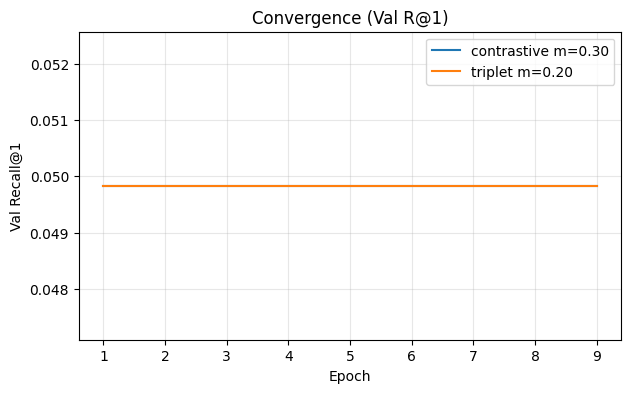

In [23]:
# Cell 19 (revised) — Plot Val R@1 vs epoch for best runs (PyTorch 2.6 safe load)
import matplotlib.pyplot as plt
import torch

def load_history(ckpt_path):
    # PyTorch 2.6 default is weights_only=True; our ckpts store numpy scalars in 'history'
    data = torch.load(ckpt_path, map_location="cpu", weights_only=False)
    return data.get("history", {})

plt.figure(figsize=(7, 4))
for r in best_rows.itertuples(index=False):
    hist = load_history(r.ckpt)
    if not hist or "epoch" not in hist or "R@1" not in hist:
        continue
    plt.plot(hist["epoch"], hist["R@1"], label=f"{r.loss} m={r.margin:.2f}")

plt.xlabel("Epoch")
plt.ylabel("Val Recall@1")
plt.title("Convergence (Val R@1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Best overall: {'loss': 'triplet', 'margin': 0.2, 'val_R@1': 0.04983388704318937, 'test_R@1': 0.09302325581395349, 'test_R@5': 0.1893687707641196, 'test_R@10': 0.25249169435215946, 'test_mAP@10': 0.13496216315983758, 'ckpt': 'outputs/contrastive/triplet_m0_20_best_pt', 'best_ep': 1}


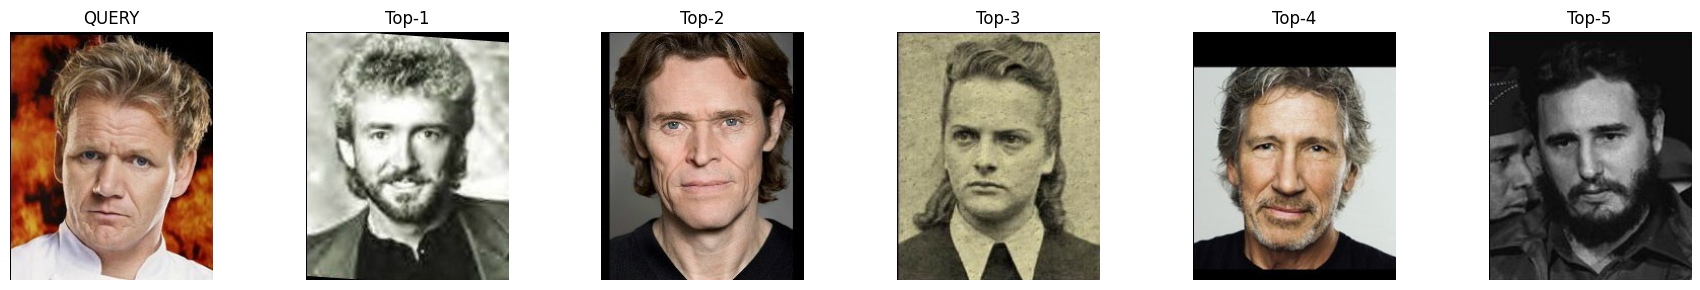

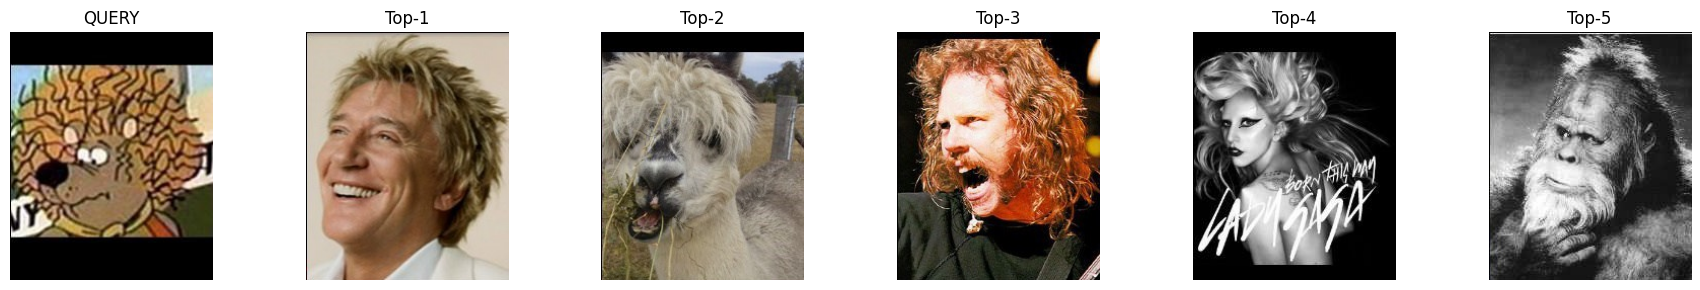

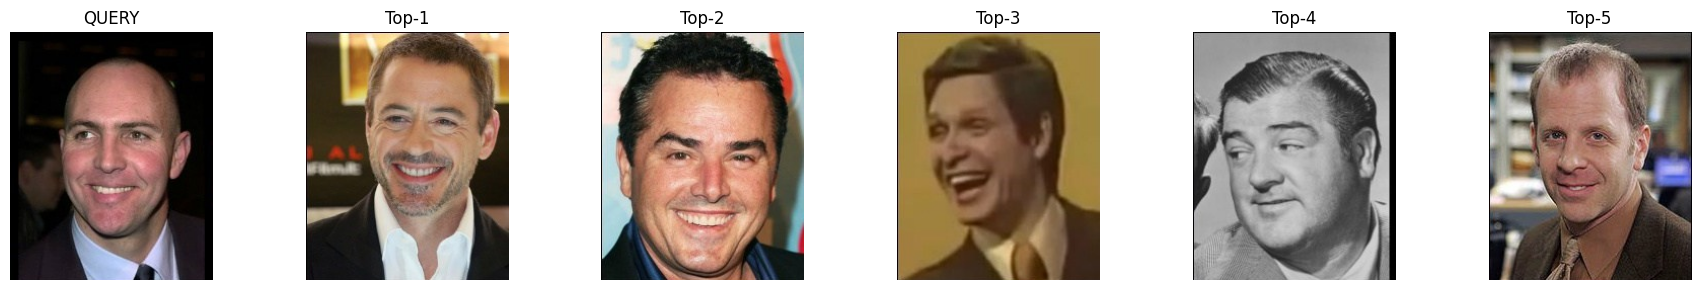

In [24]:
# Cell 20
# Build and cache NN index for TEST using the best overall model
best_overall = cmp_df.iloc[0]
print("Best overall:", best_overall.to_dict())

best_model, _ = load_model_from_ckpt(Path(best_overall["ckpt"]))
globals()["model"] = best_model  # for helpers

Q_paths_test, G_paths_test, labels_test = build_query_gallery_from_indices(test_idx)
Q_emb_test = embed_paths_batched(Q_paths_test)
G_emb_test = embed_paths_batched(G_paths_test)

nn_test = NearestNeighbors(n_neighbors=10, metric="cosine").fit(G_emb_test)
dist_test, idx_test = nn_test.kneighbors(Q_emb_test, n_neighbors=10)

def show_topk_for_test(query_idx, topk=5):
    q_path = Q_paths_test[query_idx]
    top_idx = idx_test[query_idx][:topk]
    top_paths = [G_paths_test[i] for i in top_idx]
    titles = ["QUERY"] + [f"Top-{i+1}" for i in range(topk)]
    imgs = [Image.open(q_path).convert("RGB")] + [Image.open(p).convert("RGB") for p in top_paths]
    plt.figure(figsize=(3*(topk+1), 3))
    for i, (im, t) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, topk+1, i+1)
        ax.imshow(im); ax.set_title(t); ax.axis("off")
    plt.tight_layout(); plt.show()

# Example visualizations
for q in [0, 1, 2]:
    show_topk_for_test(q, topk=5)

Best overall: {'loss': 'triplet', 'margin': 0.2, 'val_R@1': 0.04983388704318937, 'test_R@1': 0.09302325581395349, 'test_R@5': 0.1893687707641196, 'test_R@10': 0.25249169435215946, 'test_mAP@10': 0.13496216315983758, 'ckpt': 'outputs/contrastive/triplet_m0_20_best_pt', 'best_ep': 1}


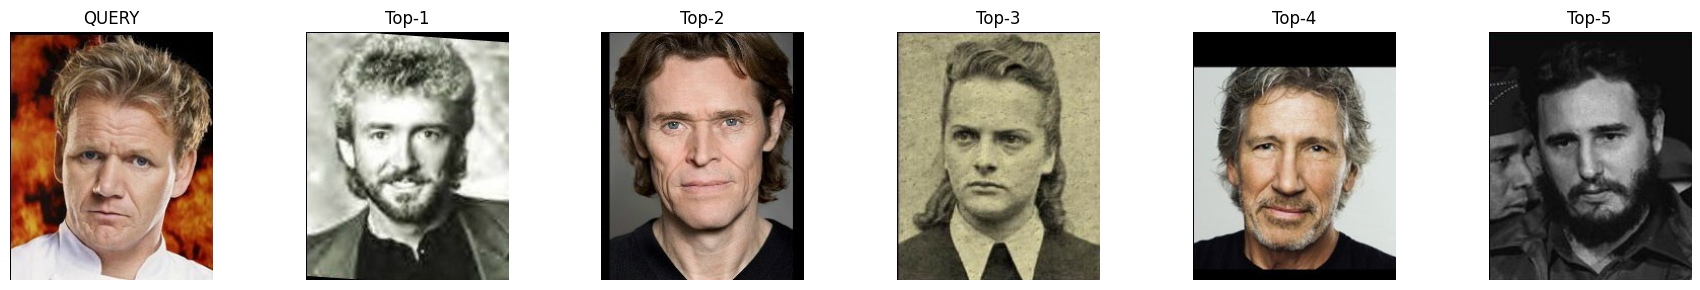

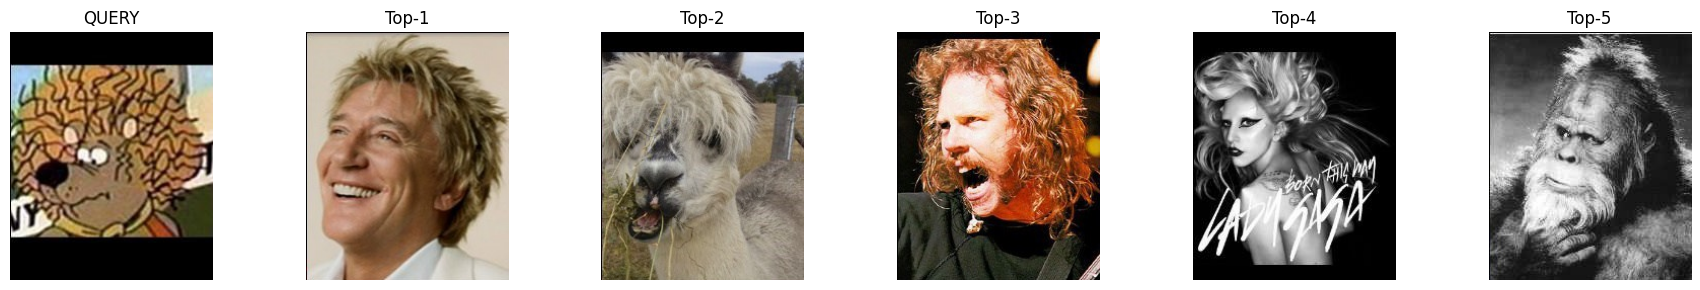

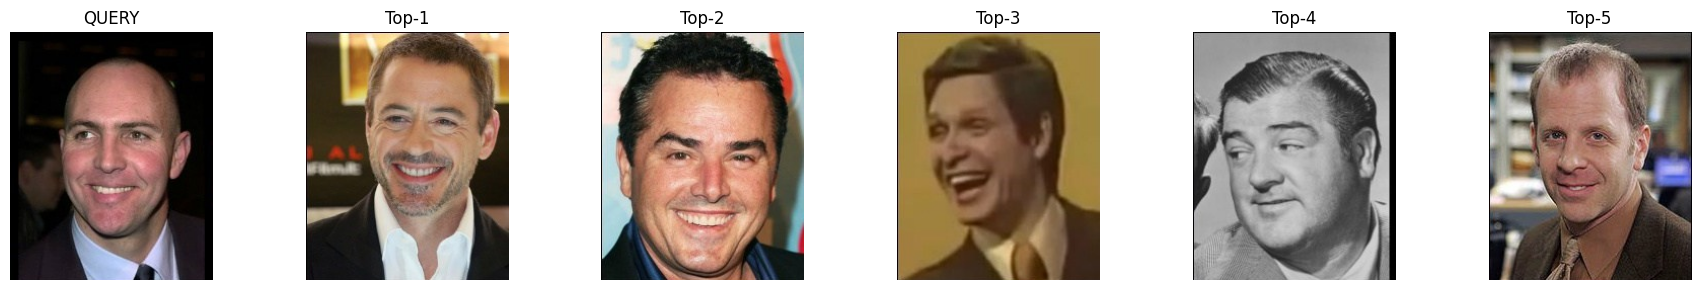

In [25]:
# Cell 20 (revised) — qualitative Top-K on TEST using the best overall model
from sklearn.neighbors import NearestNeighbors

best_overall = cmp_df.iloc[0]
print("Best overall:", best_overall.to_dict())

best_model, _ = load_model_from_ckpt(Path(best_overall["ckpt"]))
globals()["model"] = best_model  # for helpers

Q_paths_test, G_paths_test, labels_test = build_query_gallery_from_indices(test_idx)
Q_emb_test = embed_paths_batched(Q_paths_test)
G_emb_test = embed_paths_batched(G_paths_test)

nbrs_test = NearestNeighbors(n_neighbors=10, metric="cosine").fit(G_emb_test)
dist_test, idx_test = nbrs_test.kneighbors(Q_emb_test, n_neighbors=10)

def show_topk_for_test(query_idx, topk=5):
    q_path = Q_paths_test[query_idx]
    top_idx = idx_test[query_idx][:topk]
    top_paths = [G_paths_test[i] for i in top_idx]
    titles = ["QUERY"] + [f"Top-{i+1}" for i in range(topk)]
    imgs = [Image.open(q_path).convert("RGB")] + [Image.open(p).convert("RGB") for p in top_paths]
    plt.figure(figsize=(3*(topk+1), 3))
    for i, (im, t) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, topk+1, i+1)
        ax.imshow(im); ax.set_title(t); ax.axis("off")
    plt.tight_layout(); plt.show()

# Examples
for q in [0, 1, 2]:
    show_topk_for_test(q, topk=5)